
# StreamReceiver: real-time alpha band power

BCI, Neurofeedback, or any online paradigm that needs access to real-time
signals to compute a given metric can be designed with a `~bsl.StreamReceiver`.


In [1]:
# Authors: Mathieu Scheltienne <mathieu.scheltienne@fcbg.ch>
#
# License: LGPL-2.1

<div class="alert alert-danger"><h4>Warning</h4><p>Both `~bsl.StreamPlayer` and `~bsl.StreamRecorder` create a new process
    to stream or record data. On Windows, mutliprocessing suffers a couple of
    restrictions. The entry-point of a multiprocessing program should be
    protected with ``if __name__ == '__main__':`` to ensure it can safely
    import and run the module. More information on the
    [documentation for multiprocessing on Windows](https://docs.python.org/2/library/multiprocessing.html#windows).</p></div>

This example will use a sample EEG resting-state dataset that can be retrieve
with `bsl.datasets <api/utils:Datasets>`. The dataset is stored in the user home
directory in the folder ``bsl_data`` (e.g. ``C:\Users\User\bsl_data``).



In [2]:
import os
import time
from pathlib import Path

import mne
import numpy as np
from matplotlib import pyplot as plt

from bsl import StreamPlayer, StreamReceiver, StreamRecorder, datasets
from bsl.triggers import MockTrigger
from bsl.utils import Timer

To simulate an actual signal coming from an LSL stream, a `~bsl.StreamPlayer`
is used with a 40 seconds resting-state recording.



In [3]:
stream_name = "StreamPlayer"
fif_file = datasets.eeg_resting_state.data_path()
player = StreamPlayer(stream_name, fif_file)
player.start()
print(player)

<Player: StreamPlayer | ON | C:\Users\pipo_\bsl_data\eeg_sample\resting_state-raw.fif>


## Basics of StreamReceiver

Now that a `~bsl.StreamPlayer` is streaming data, a `~bsl.StreamReceiver` is
defined to access it in real-time.



In [4]:
receiver = StreamReceiver(bufsize=2, winsize=1, stream_name="obci_eeg1")
time.sleep(2)  # wait 2 seconds to fill LSL inlet.

<div class="alert alert-info"><h4>Note</h4><p>A `~bsl.StreamReceiver` opens an LSL inlet for each connected stream at
    initialization. The inlet's buffer is empty when created and fills up as
    time passes. Data is pulled from the LSL inlet each time
    `~bsl.StreamReceiver.acquire` is called.</p></div>

<div class="alert alert-danger"><h4>Warning</h4><p>If the `~bsl.StreamReceiver` buffer/window is large and data is pulled
    too often from the LSL inlet, there might not be enough new samples to
    pull an entire window/buffer length.</p></div>



In [5]:
receiver.acquire()
data1, timestamps1 = receiver.get_window()
print(data1.shape)
time.sleep(1)
receiver.acquire()
data2, timestamps2 = receiver.get_window()
print(data2.shape)
receiver.acquire()
data3, timestamps3 = receiver.get_window()
print(data3.shape)

(250, 9)
(250, 9)
(250, 9)


In [5]:
print(data1.T)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 3.22346759  2.84596229  2.26003027 ... -1.86474478 -1.74886405
  -1.59379733]
 [ 1.04205716  0.53367758 -0.16495588 ...  0.07031702  0.44368479
   0.65632612]
 ...
 [ 1.64314497  1.62536538  1.66191757 ...  3.47350931  3.29658222
   3.08710861]
 [ 4.41814899  4.37074709  4.24064064 ...  4.05412388  4.23795462
   4.30520105]
 [-5.33702755 -5.55885029 -5.61566257 ...  6.26848698  6.58515501
   6.8301897 ]]


The code snippet above retrieved 3 different windows of 1 second each from
the LSL stream sampled @ 512 Hz. The first window is retrieved 2 seconds
after the `~bsl.StreamReceiver` was created. The second window is retrieved 1
second after the second window. The third window is retrieved right after the
second window.

Let's visualize how this 3 different window are placed on the timeline:



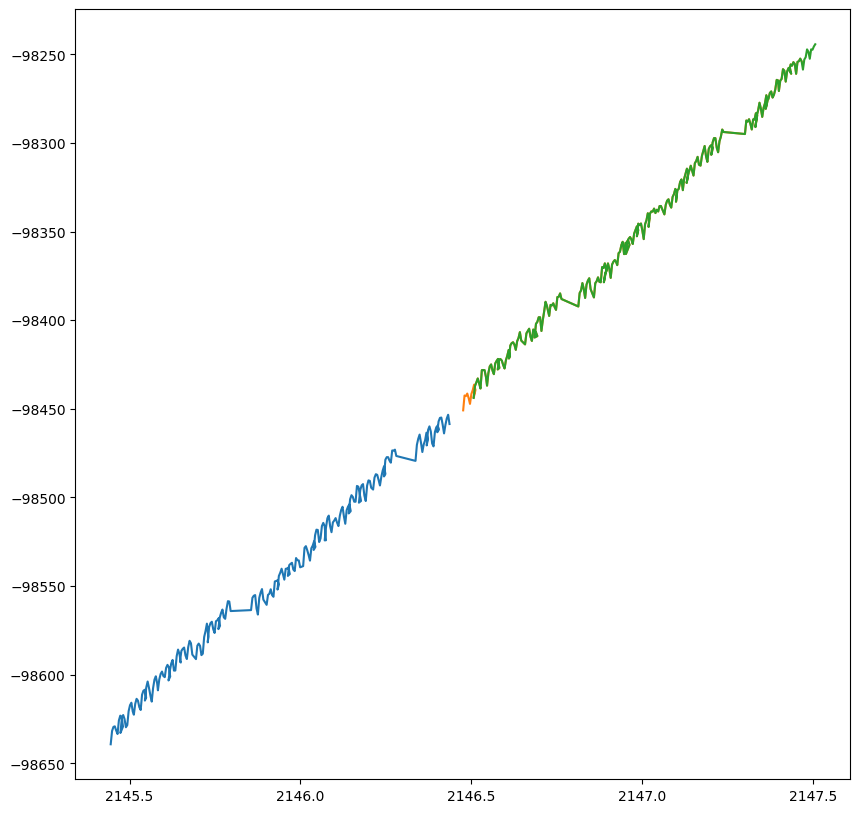

In [7]:
idx = 2  # Select one channel
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(timestamps1, data1[:, idx], color="#1f77b4")
ax.plot(timestamps2, data2[:, idx], color="#ff7f0e")
ax.plot(timestamps3, data3[:, idx], color="#2ca02c")

As expected, the second and third window are mostly overlapping and contains
mostly the same data. To improve visualization, each window can be shifted
vertically with a fix offset:



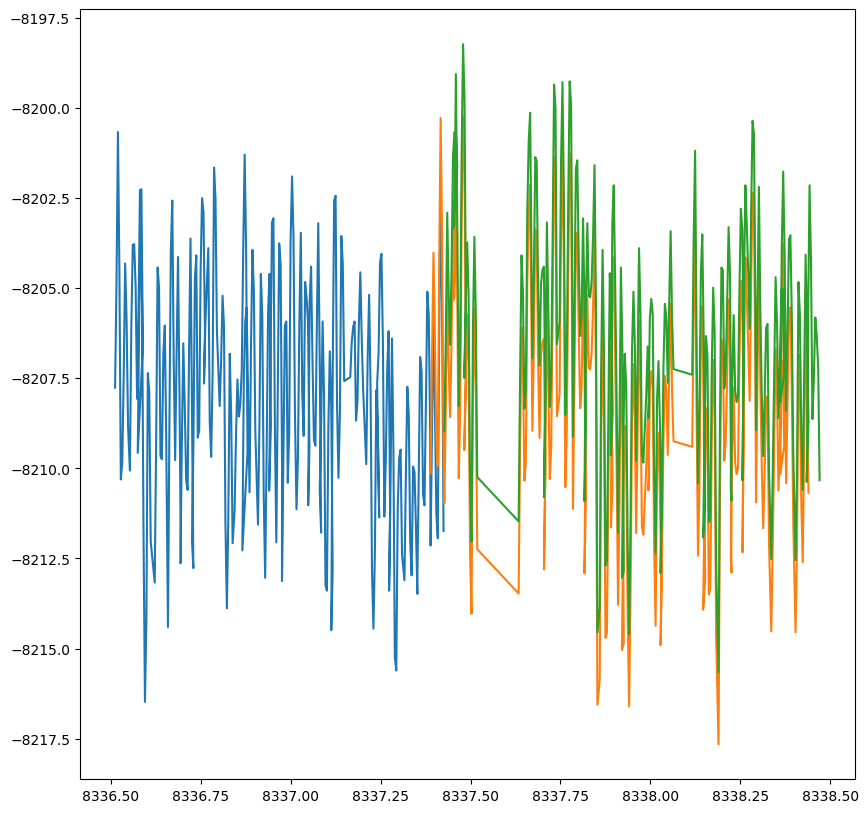

In [8]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(timestamps1, data1[:, idx], color="#1f77b4")
ax.plot(timestamps2, data2[:, idx] + 2, color="#ff7f0e")
ax.plot(timestamps3, data3[:, idx] + 4, color="#2ca02c")

Finally, the `~bsl.StreamReceiver.get_window` and
`~bsl.StreamReceiver.get_buffer` methods are only getters and do not modify
the buffer. Pulling new data in the buffer is only done in a separate Thread
by `~bsl.StreamReceiver.acquire`. The exact timings at which the
`~bsl.StreamReceiver` acquires new data is left to the discretion of the
user.



In [9]:
data4, timestamps4 = receiver.get_window()
print((data4 == data3).all(), (timestamps4 == timestamps3).all())

True True


## Online loop with a StreamReceiver

The example below is a simple online loop shifting between 2 phases lasting
each 3 seconds. The loop will stop once each phase has been experienced
twice, thus after 12 seconds. The beginning of each phase is marked with a
trigger event, (1) or (2).

As an example, the alpha band power will be computed for each phase on 1
second successive acquisition window.



In [10]:
# FFT settings
winsize_in_samples = receiver.streams["obci_eeg1"].sample_rate * receiver.winsize
sample_spacing = 1.0 / receiver.streams["obci_eeg1"].sample_rate
frequencies = np.fft.rfftfreq(n=int(winsize_in_samples), d=sample_spacing)
alpha_band = np.where(np.logical_and(0 <= frequencies, frequencies <= 60))[0]
fft_window = np.hanning(winsize_in_samples)

# Loop settings
n_cycles = 2  # 2 alternation of phases
phase_duration = 3  # in seconds

Acquired data is saved to disk with a `~bsl.StreamRecorder` and the beginning
of each phase is marked with a trigger event. For this example, a
`~bsl.triggers.MockTrigger` is used, but this example would be
equally valid with a different type of trigger.



In [11]:
record_dir = Path("~/bsl_data/examples").expanduser()
os.makedirs(record_dir, exist_ok=True)
recorder = StreamRecorder(record_dir, fname="example_real_time")
recorder.start()
print(recorder)
trigger = MockTrigger()

<Recorder: All streams | ON | C:\Users\pipo_\bsl_data\examples>


The 2 first events, ``phase1`` and ``phase2`` are defined with their
respective timings as tuples ``(timing, event)``. The timing are offset by 0.2
to give a little headroom to the script and to avoid clipping the first
phase.

The values used to mark the beginning of each phase are stored in a `dict`.



In [12]:
offset = 0.2  # offset to avoid clipping the first phase
events = [(offset, "phase1"), (offset + phase_duration, "phase2")]
trigger_values = {"phase1": 1, "phase2": 2}

There is actually 2 nested online loops: one to switch between phases and one
to acquire data and compute the alpha band power inside a phase.



In [13]:
# number of time each phase has been experienced
n = 1

# list to store results
alphas = list()
timings = list()

# timers
paradigm_timer = Timer()  # timer used to switch between phases
phase_timer = Timer()  # timer used within a phase to count the duration

next_event_timing, event = events.pop(0)
while n <= n_cycles:
    if next_event_timing <= paradigm_timer.sec():
        # schedule next similar event
        events.append((next_event_timing + 2 * phase_duration, event))

        # add new result list
        alphas.append([])
        timings.append([])

        # reset timer and send trigger
        phase_timer.reset()
        trigger.signal(trigger_values[event])

        while phase_timer.sec() <= phase_duration:
            # acquisition
            receiver.acquire()
            raw, samples = receiver.get_window(return_raw=True)

            if samples.shape[0] != winsize_in_samples:
                continue  # skip incomplete windows

            # processing
            raw.set_eeg_reference(ref_channels="average", projection=False)
            data = raw.pick(picks="eeg", exclude="bads").get_data()
            data = np.multiply(data, fft_window)
            fftval = np.abs(np.fft.rfft(data, axis=1) / data.shape[-1])
            alpha = np.average(np.square(fftval[:, alpha_band]).T)

            # append to result list
            alphas[-1].append(alpha)
            timings[-1].append(samples[0])

        # increment if this is the second phase
        if event == "phase2":
            n += 1
        # Retrieve next event
        next_event_timing, event = events.pop(0)

# close the trigger and stop the recorder
del trigger
recorder.stop()

As you may have noticed, `~bsl.StreamReceiver.get_window` or
`~bsl.StreamReceiver.get_buffer` return by default data as a `numpy.array`,
but it can also be return directly as a `~mne.io.Raw` instance if the
argument ``return_raw`` is set to ``True``.

Depending on the CPU, on the current CPU load, and on the processing applied,
the number of acquired window (points) may vary.



[76, 76, 76, 75]
[76, 76, 76, 75]


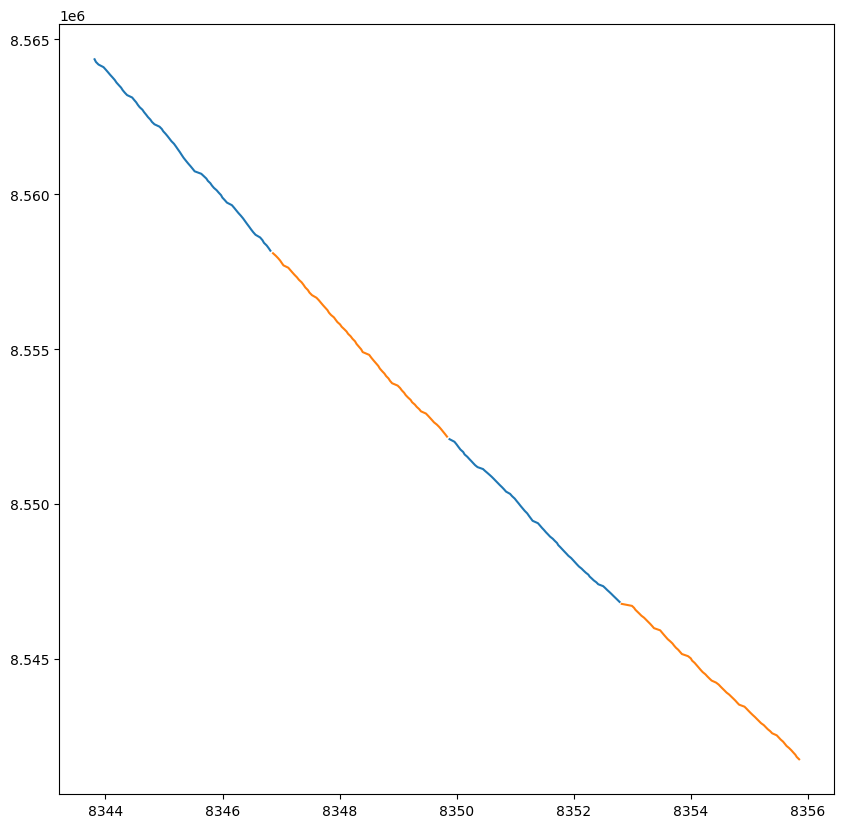

In [14]:
print([len(a) for a in alphas])
print([len(t) for t in timings])

f, ax = plt.subplots(1, 1, figsize=(10, 10))
for k in range(len(alphas)):
    color = "#1f77b4" if k % 2 == 0 else "#ff7f0e"
    ax.plot(timings[k], alphas[k], color=color)

The saved `~mne.io.Raw` instance can then be loaded and analyzed.



In [15]:
fname = record_dir / "fif" / "example_real_time-StreamPlayer-raw.fif"
raw = mne.io.read_raw_fif(fname, preload=True)
print(raw)

<Raw | example_real_time-StreamPlayer-raw.fif, 65 x 6625 (12.9 s), ~3.4 MB, data loaded>


Stop the mock LSL stream.



In [16]:
# del receiver  # disconnects and close the LSL inlet.
# player.stop()